In [14]:
%matplotlib inline
import json
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib

Firstly, we want to define a function that will grab all of our comment data and convert it to dictionaries from JSON.

In [2]:
def parse_comment_file():
    """
    Parse each comment in the JSON file into a dict and then add it to a list, then return the list
    """
    # Empty list for storage
    comment_list = []

    # Open the file
    with open('nikskoCommentsToAugust2015.json', 'r') as file:
        # For every line
        for line in file:
            # Parse the line into a dict
            comment_dict = json.loads(line)
            # Put the dict on the end of the list
            comment_list.append(comment_dict)

    return comment_list

Now we can do some analysis. Firstly, we'll look at comment frequency, both by day and by month.

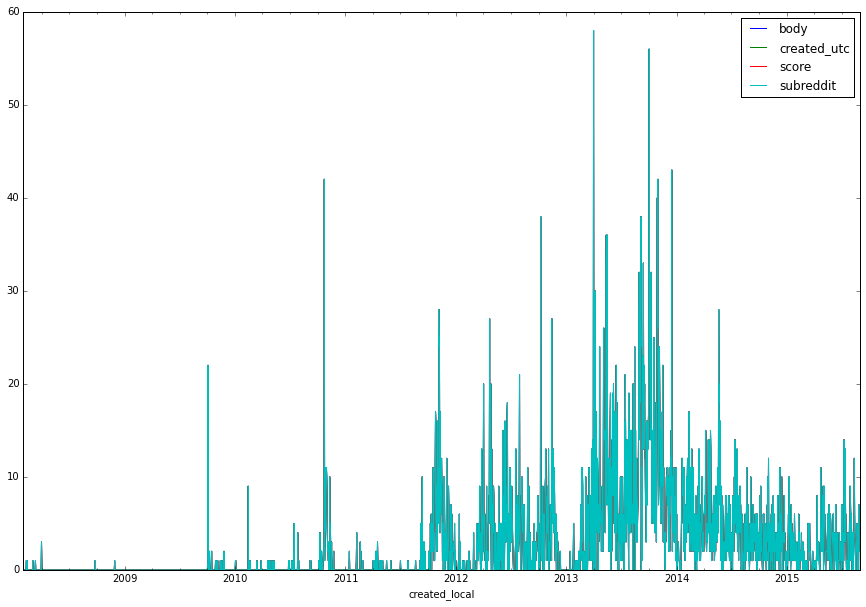

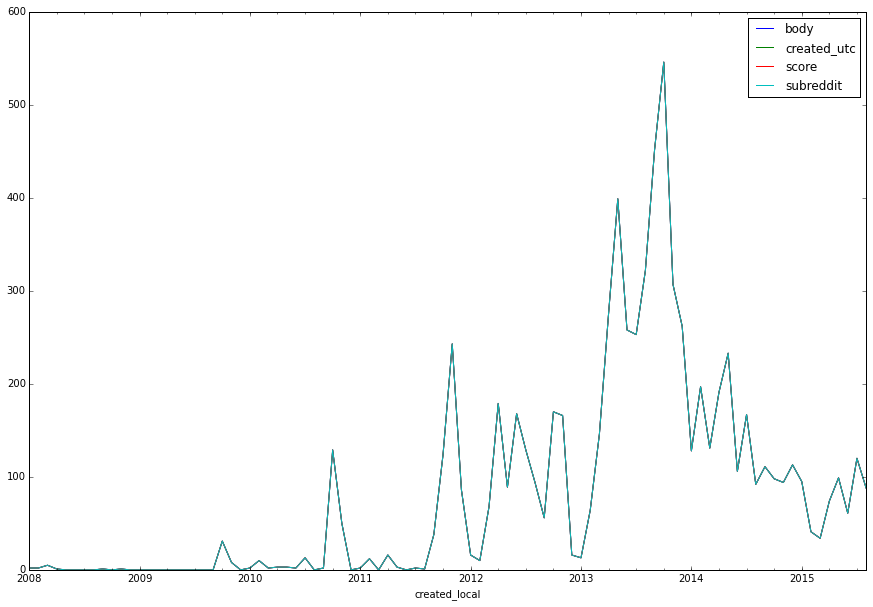

In [18]:
# Parse the file
comment_list = parse_comment_file()

# Sort the list based on the UTC time
comment_list.sort(key=lambda x: x['created_utc'])

# Throw this into a pandas dataframe
comment_frame = pd.DataFrame(comment_list)

# Fix the datatypes on the columns
comment_frame[['created_utc', 'score']] = comment_frame[['created_utc', 'score']].astype(int)
comment_frame[['subreddit', 'body']] = comment_frame[['subreddit', 'body']].astype(str)

# Convert from unix UTC dates to local times
comment_frame['created_local'] = pd.to_datetime(comment_frame['created_utc'], unit='s')

# Set the created_local as the index
comment_frame = comment_frame.set_index('created_local')

# Resample daily and count
daily_frame = comment_frame.resample('D', how='count')

# Plot the results
daily_frame.plot(figsize=(15,10))

# Resample monthly and count
monthly_frame = comment_frame.resample('M', how='count').interpolate(method='cubic')

# Plot
monthly_frame.plot(figsize=(15,10))

Next we'll look at comment breakdown by subreddit.

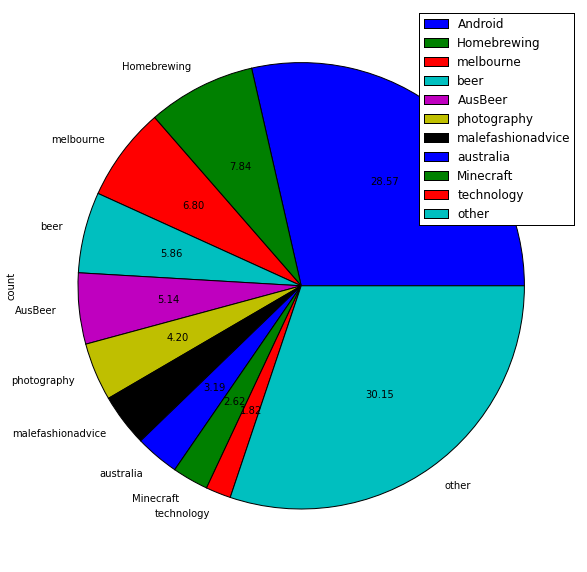

In [82]:
NUM_RESULTS = 10

# Count comments by subreddit
subreddit_frame = comment_frame.groupby('subreddit').count()

# Drop unneeded columns
subreddit_frame = subreddit_frame.drop(['created_utc', 'score'], 1)
subreddit_frame['count'] = subreddit_frame['body']
subreddit_frame = subreddit_frame.drop('body', 1)

# Sort based on count, descending
subreddit_frame = subreddit_frame.sort('count', ascending=False)

# Grab the top 20 entries and put them into a new frame
pie_frame = subreddit_frame.head(NUM_RESULTS)

# Aggregate the remaining entries and add them as an other entry
other_count = int(subreddit_frame.iloc[NUM_RESULTS:].sum())

pie_frame = pie_frame.append(pd.DataFrame({'count':other_count}, index=['other']))

pie_frame
pie_frame.plot(y='count', kind='pie', figsize=[10, 10], autopct='%.2f')